In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm

In [20]:
# данные по оси Х от 0 до 6*pi с шагом 0.01
X = np.arange(0, 6 * np.pi, 0.01)
# данные по оси Y sin(X) с разбросом в 1.5 интервала
y = np.sin(X) + 1.5 * np.random.rand(len(X))
# создадим шум из каждого 20го числа
y[::20] = 5 * np.random.rand(len(y[::20])) - 2

px.scatter(x=X, y=y).show()

X = X.reshape(-1, 1)

In [24]:
# объявим слабый классификатор
clf = DecisionTreeRegressor(max_depth=1)
# обучим
clf.fit(X, y)

DecisionTreeRegressor(max_depth=1)

In [27]:
# визуализируем работу слабого классификатора
fig = px.scatter(x=X.ravel(), y=y)

y_hat = clf.predict(X)

fig.add_trace(go.Scatter(x=X.ravel(), y=y_hat)).show()

In [29]:
# вычтем предсказания классификатора из y_true
y1 = y - y_hat

px.scatter(x=X.ravel(), y=y1).show()

In [30]:
# объявим новый слабый классификатор и обучим его на новых метках
clf1 = DecisionTreeRegressor(max_depth=1)
clf1.fit(X, y1)

DecisionTreeRegressor(max_depth=1)

In [32]:
# визуализируем работу нового классификатора
fig = px.scatter(x=X.ravel(), y=y1)
y_hat = clf1.predict(X)
fig.add_trace(go.Scatter(x=X.ravel(), y=y_hat)).show()

In [33]:
# вычтем предикты второго классификатора из меток первого классификатора
y2 = y1 - y_hat

px.scatter(x=X.ravel(), y=y2).show()

In [34]:
clf2 = DecisionTreeRegressor(max_depth=1)
clf2.fit(X, y2)

DecisionTreeRegressor(max_depth=1)

In [35]:
fig = px.scatter(x=X.ravel(), y=y2)
y_hat = clf2.predict(X)
fig.add_trace(go.Scatter(x=X.ravel(), y=y_hat)).show()

In [36]:
y3 = y2 - y_hat

px.scatter(x=X.ravel(), y=y3).show()

In [37]:
from sklearn.svm import LinearSVR

In [38]:
clf4 = LinearSVR()
clf4.fit(X, y3)

D:\PyProjects\practicum_ds\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVR()

In [39]:
fig = px.scatter(x=X.ravel(), y=y3)
y_hat = clf4.predict(X)
fig.add_trace(go.Scatter(x=X.ravel(), y=y_hat)).show()

In [40]:
y4 = y3 - y_hat

px.scatter(x=X.ravel(), y=y4).show()

In [41]:
fig = px.scatter(x=X.ravel(), y=y)
y_hat_final = clf.predict(X) + clf1.predict(X) + clf2.predict(X) + clf4.predict(X)
fig.add_trace(go.Scatter(x=X.ravel(), y=y_hat_final)).show()

---

Напишем свою функцию для реализации бустинга слабых классификаторов и визуализируем результаты ее работа

In [46]:
model = DecisionTreeRegressor(max_depth=1)

X = np.arange(0, 6 * np.pi, 0.01)

y = np.sin(X) + 1.5 * np.random.rand(len(X))
y[::20] = 5 * np.random.rand(len(y[::20])) - 2.5

# датафрейм для удобства
data = pd.DataFrame(
	{
        'feature': X,
        'target': y
    }
)

features = data.drop('target', axis=1)
target = data['target']

In [43]:
def boosted(clf, X, y, n_boost):
    y_hat_final = y_pred = np.zeros(y.shape) # заполним нулями для первой итерации цикла, когда y_pred отсутствует
    for _ in range(0, n_boost):
        y = y - y_pred
        clf.fit(X, y)
        y_pred = clf.predict(X)
        y_hat_final += y_pred
    return y_hat_final

In [51]:
y_boosted = boosted(model, features, target, 1000)

In [52]:
fig = px.scatter(x=features['feature'], y=target)
fig.add_trace(go.Scatter(x=features['feature'], y=y_boosted, name='Предсказание модели'))

fig.update_layout(
    dict(
        title='Предикт после кастомного бустинга',
        xaxis_title='Данные по оси X',
        yaxis_title='Данные по оси Y',
        legend_orientation='h',
        legend=dict(x=.85, y=0)
    )
)

fig.show()

---

Реализуем класс для бустинга слабых классификаторов и визуализируем результаты его работы

In [63]:
class MyBoosting:
    def __init__(self, base_clf, n_clfs: int, max_depth: int = 1):
        self.fitted_models: list = []
        self.base_clf = base_clf
        self.n_clfs = n_clfs
        self.boosted_predictions: list
        self.max_depth = max_depth

    def __get_zero_y_pred(self, y):
        return np.zeros(y.shape)

    def fit(self, X, y):
        # начальные значения для финального результата (y_hat_final)
        # и предикта каждой модели (y_pred для первой итерации цикла)
        y_hat_final = self.__get_zero_y_pred(y)
        for _ in tqdm(range(0, self.n_clfs)):
            self.model = self.base_clf(max_depth=self.max_depth).fit(X, y)
            y_pred = self.model.predict(X)
            y = y - y_pred
            y_hat_final += y_pred
            self.fitted_models.append(self.model)
        self.boosted_predictions = y_hat_final

    def predict(self, X):
        # возвращаем сумму предиктов ансамбля
        return np.sum([model.predict(X) for model in self.fitted_models], axis=0)


In [70]:
model = MyBoosting(DecisionTreeRegressor, 20, max_depth=2)
model.fit(features, target)
boosted_pred = model.boosted_predictions

  0%|          | 0/20 [00:00<?, ?it/s]

In [71]:
fig = px.scatter(x=features['feature'], y=target)
fig.add_trace(go.Scatter(x=features['feature'], y=boosted_pred, name='Предсказание модели'))

fig.update_layout(
    dict(
        title='Предикт после кастомного бустинга',
        xaxis_title='Данные по оси X',
        yaxis_title='Данные по оси Y',
        legend_orientation='h',
        legend=dict(x=.85, y=0)
    )
)

fig.show()

In [82]:
# формируем новый датасет для проверки предикта предобученного бустинга
X = np.arange(0, 6 * np.pi, 0.01)

y = np.sin(X) + 1.5 * np.random.rand(len(X))
y[::20] = 5 * np.random.rand(len(y[::20])) - 2.5

# датафрейм для удобства
data = pd.DataFrame(
	{
        'feature': X,
        'target': y
    }
)

features = data.drop('target', axis=1)
target = data['target']

In [83]:
boosted_pred = model.predict(features)

In [84]:
fig = px.scatter(x=features['feature'], y=target)
fig.add_trace(go.Scatter(x=features['feature'], y=boosted_pred, name='Предсказание модели'))

fig.update_layout(
    dict(
        title='Предикт после кастомного бустинга',
        xaxis_title='Данные по оси X',
        yaxis_title='Данные по оси Y',
        legend_orientation='h',
        legend=dict(x=.85, y=0)
    )
)

fig.show()

---

# Блендинг


In [85]:
from sklearn.model_selection import KFold

from sklearn.datasets import make_classification

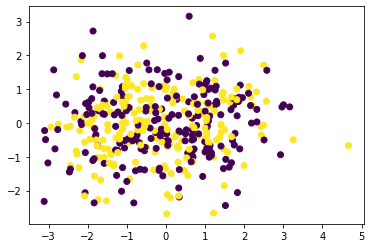

In [141]:
X, y = make_classification(400, n_classes=2, n_informative=3)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X, X_test, y, y_test  = train_test_split(X, y, test_size = 20)

In [89]:
X.shape, X_test.shape, y.shape, y_test.shape

((80, 2), (20, 2), (80,), (20,))

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [91]:
import pandas as pd

In [92]:
clfs = [DecisionTreeRegressor(max_depth=1), KNeighborsClassifier(2)]

kfold = KFold(5, shuffle=True, random_state=42)


X_meta = {clf.__class__.__name__: [] for clf in clfs}

y_overall = []
for train_idx, valid_idx in kfold.split(X):

    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    for clf in clfs:
        clf.fit(X_train, y_train)
        X_meta[clf.__class__.__name__].append(clf.predict(X_valid))
    
    y_overall.append(y[valid_idx])

X_meta = pd.DataFrame({k: np.concatenate(X_meta[k]).T for k in X_meta})

y_overall = np.concatenate(y_overall)

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
from sklearn.metrics import f1_score

In [95]:
meta = LogisticRegression()

meta.fit(X_meta.values, y_overall)

LogisticRegression()

In [96]:
X_meta_test = np.stack([clf.predict(X_test) for clf in clfs]).T

In [97]:
y_test_pred = meta.predict(X_meta_test)

In [98]:
f1_score(y_test, y_test_pred)

0.9600000000000001

In [99]:
f1_score(y_test, clfs[1].predict(X_test))

0.8695652173913043

In [100]:
f1_score(y_test, clfs[0].predict(X_test) > 0.5)

1.0

In [101]:
meta.coef_

array([[2.20234086, 1.38799122]])